# Randomization
A common trait to all the maze generation algorithms is randomization. To try and eradicate any bias that mazes might have we try and make them as random as possible. To generate random numbers we used the random library in python under the belief that it is truly random. But how random are the numbers generated by this 'random' function?

In [4]:
# Random functions and visualizer tool 
import random
import matplotlib.pyplot as plt
import time

In [5]:
def analyse(x, y, n, m):
    for i in range(0, n):
        y[i] /= m

    # Get mean and variance
    temp = []
    for i in range(0, n):
        temp.append(x[i]*y[i])

    mean = sum(temp)

    for i in range(0, n):
        temp[i] *= x[i]
    variance = sum(temp) - mean**2

    plt.plot(x, y)
    plt.ylabel("Probability")
    print("Mean     : ", mean)
    print("Variance : ", variance)

In [20]:
# Here we just create 10000 random numbers, and plot a distribution
# The seed for random is omitted to use the system time

# X is used to plot our distribution
x = list(range(0, 10000))

# Y stores the number of times each number is generated
y = [0]*10000

# Generate the random numbers and store them in the list
for i in range(0, 100000):
    y[random.randint(0, 9999)] += 1


Mean     :  5011.873159999997
Variance :  8353326.9500316605


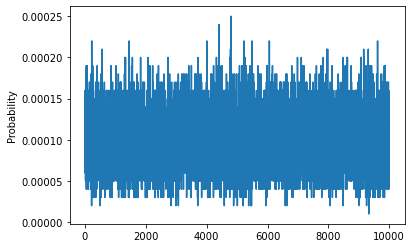

In [21]:
analyse(x, y, 10000, 100000)

## What does the above figure mean?
As we can see, the distribution is not very even. There exists some bias in the random numbers generated, and the distribution obtained is not really uniform. Although the mean value is pretty close to our expected mean, the variance is huge implying a large spread in the data. If it is difficult to see the differences in this image, lets take a look at only the first 10 numbers.

Mean     :  4.48091
Variance :  8.282055571900003


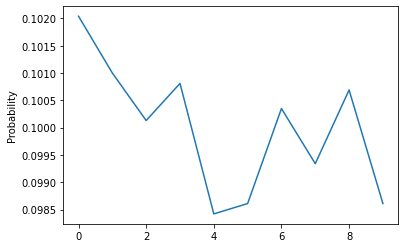

In [22]:
x = list(range(0, 10))
y = [0]*10

# Generate the random numbers and store them in the list
for i in range(0, 100000):
    y[random.randint(0, 9)] += 1

analyse(x, y, 10, 100000)

As we can see, the distribution of the numbers obtained is not uniform even for a small range, and hence there is a very strong bias. The distribution is not even near uniform, as the variance is a large number, even though the mean is close to what we would expect it to be. If the random number generation in python isn't really random, how do we generate truly random numbers?

## Pseudo-random number generators
We know that computers are entirely deterministic. To generate random numbers we need some unpredictable phenomena that occur frequently so we can harness their randomness. Nature does offer a lot of randomness, but it is infeasible to extract a random number from nature. So how do we make a deterministic machine produce near random results?
### Properties of PRNGs
#### Efficient
We want to be able to obtain a random number in a short span of time, or even multiple random numbers in parallel. Speed is paramount to random number generation like it is to most other algorithms.
#### Deterministic
We try and simulate randomness on a deterministic machine, and hence the result will also be deterministic. Since most PRNGs use an initial 'seed' to start, we could replicate the exact sequence of random numbers obtained if we have the seed. 
#### Periodic
PRNGs are generally periodic and repeat themselves after a finite time. However the period of PRNGs we use today are so long that they do not really affect most programs. 
#### Pseudo-random
We want to try and generate numbers that are near random, but we can't on a deterministic machine. With this in mind, let us change our goal to trying to generate numbers such that they are indistinguishable from truly random numbers. This means that no Turing machine will be able to recognize whether the number was calculated or random.

### Linear congruence generator
The linear congruence generator is a very simple PRNG that has been used extensively in the past. It works on the simple equation, 
$X_{n+1} = (aX_n+c)\ mod\ m$  
Where X is the series of pseudo random numbers,  
      m is some number that serves as the modulus,  
      a is the multiplier and,  
      b is the incrementer.  
Let us try and use this to generate random numbers in python. 

In [23]:
# Here we will consider numbers in the range of 0, 10000, and generate n numbers
def LinearCongruence(m, n):
    # The seed for the random number generator 
    X_0 = (int)(time.time())
    # Hard coding large primes for a, b and m
    a = 17599
    b = 997627
    
    # List to hold the frequencies of the numbers generated
    freq = [0]*m
    
    for i in range(0, n):
        X_0 = (a*X_0+b)%m
        freq[X_0] += 1
    
    return freq

Mean     :  5013.499999999999
Variance :  8336512.250000011


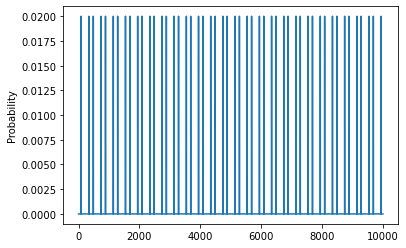

In [24]:
# Now we use the PRNG to generate numbers and analyse again 
x = list(range(0, 10000))
y = LinearCongruence(10000, 100000)
analyse(x, y, 10000, 100000)

Here we can clearly see that the function is periodic, and  spikes at certain values. Although this level of determinism is probably due to the numbers that I chose, we ca conclude that this method is not a good way to generate random numbers. However, let us try and check for a smaller modulo.

Mean     :  3.5
Variance :  2.25


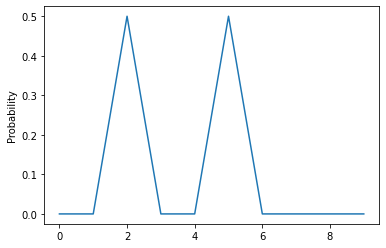

In [26]:
x = list(range(0, 10))
y = LinearCongruence(10, 100000)
analyse(x, y, 10, 100000)

Again we can see that the probabilities cycle between values, this time with a period of only two. This indicates that a linear congruence method to generate random numbers isn't very good, and won't be effective. However we could cascade this randomness by cycling between these values a 'random' number of times to get a more unpredictable result.

## One way permutation method
This is a method I came up with after thinking about random number generation. The idea is to take an input bit string, and output an even larger bit string after applying some transforms on the original bitstring. The longer the output bitstring, the harder it is for a deterministic machine to figure out whether it was calculated or random. Using from knowledge from the blockchain course offered in college, here is what I realized.
If p is prime and 0 < x < p-1,  
$f(x)\ = g^x\ mod\ p$  
And g is chosen to be a generator from the group $Z_p$  
This function is a well known one way function, as computing the inverse is very difficult due to collisions. This function however takes a single bitstring of length k, and returns another bitstring of length k. To increase the randomness, we need to increase the number of bits. To add another bit, let's just take the xor of all the bits obtained by xoring all the bits of our bitstring with the obtained bitstring.  
Now we can proceed to build a PRNG using the above results.

In [6]:
# Some constants used, MOD is the prime, GEN is the generator and length is the length of the input bitstring 
MOD = 36389
GEN = 223
LEN = 16

func_range = lambda x: x**2 - 2*x + 1

def f(lh, rh):
    res = bin(pow(GEN, int(lh, 2), MOD)).replace('0b', '').zfill(LEN)
    extra_bit = 0
    for i in range(len(lh)):
        extra_bit = (extra_bit ^ (int(lh[i]) & int(rh[i]))) % 2
    return res + rh + str(extra_bit)

def PRNG(seed):
    string = seed
    result = ''
    for i in range(func_range(LEN)):
        lh = string[:int(len(string)/2)]
        rh = string[int(len(string)/2):]
        string = f(lh, rh)
        result += string[-1]
        string = string[:-1]
    return result

# Convert an integer to its equivalent bitstring
def itobs(x):
    return "{0:b}".format(x)

# Convert a bitstring to its equivalent integer
def bstoi(x):
    return int(x, 2)

Mean     :  48.205999999999996
Variance :  939.619564000001


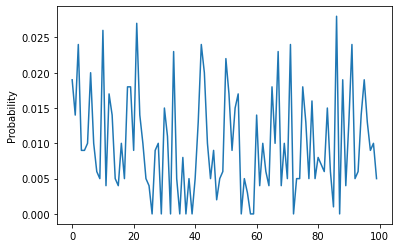

In [42]:
x = list(range(0, 100))
y = [0]*100

seed = 16543
bs = seed

for i in range(0, 1000):
    bs = itobs(bs)
    ret_string = PRNG(bs[0 : LEN])
    ans = bstoi(ret_string)
    bs = ans
    ans %= 100
    y[ans] += 1

analyse(x, y, 100, 1000)

## Result
Here we can see that the distribution is clearly not uniform. However, our seed was taken from the previous answer resulting in a cyclic series which detracts from the use case of this PRNG. This PRNG is designed to return a number that is indistinguishable, and longer bitstring than the input. With that in mind, let us look at the output for some integer. 

In [8]:
seed1 = 16453
bs = itobs(seed1)
ret_string = PRNG(bs[0:LEN])
print(bs)
print(ret_string)

100000001000101
000000011010101100001110100011101100001010001110011000001100010001010101000101010100001011000111010101111001000111111010010100010111000011010101100001100000000001100110011111000100100011111000010001101000000110000111001101011


As we can see here, the function takes a 16 bit bitstring and converts it to a 225 bit bitstring. This is very difficult to invert (convert the 225 bit bitstring to the 16 bit bitstring) due to the one way property of modulo under a generator of the group. Our goal of creating a PRNG that is kind of random, and difficult to invert has been achieved. However this generator still doesn't compare the the python PRNG, and therefore for our remaining randomization we will be sticking to randint(). With the advent of quantum computing and the Hadamard gate, we will be able to generate truly random numbers and eliminate bias from our mazes further.